<a href="https://colab.research.google.com/github/kaledai069/Crossword-Generator/blob/master/British_Styled_Crosswords_Scrapper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q git+https://github.com/alexdej/puzpy.git
!pip install -q xword-dl

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.0/143.0 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.8/293.8 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 19.4 MB/s eta 0:00:00


In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime
import subprocess
import puz
import glob
import os
import json

from math import floor, ceil
from PIL import Image, ImageDraw, ImageFont

### British-Style Crossword Grid Generator

In [ ]:
def generate_british_style(arr):
    random_indices = [i * 2 for i in range(len(arr[0]) // 2)]

    selected = random.sample(random_indices, len(random_indices) // 4)

    selected2 = [index + 1 for index in selected]
    random.shuffle(selected2)

    for i in range(len(arr)):
        if i % 2 == 0:
            if i not in selected:
                arr[i][random.randint(0, len(arr[i]) - 1)] = '*'
        else:
            for j in range(len(arr[i])):
                if j % 2 == 1:
                    arr[i][j] = '*'
            if i in selected2:
                s = random.randint(0, len(arr[i]) - 1)
                if s % 2 == 1:
                    s -= 1
                arr[i][s] = '*'

# Example usage:
rows = 5
columns = 5
grid_size = 21
grid = [[' ' for _ in range(grid_size)] for _ in range(grid_size)]
generate_british_style(grid)

In [ ]:
def visualize_crossword_image(grid, black_cell_str = '*', grid_nums = None, cell_size = 30, black_square_color="black", text_color="black", image_file="crossword.png"):
    """
    Create an image representation of the crossword grid.

    Parameters:
    - grid (list): The crossword grid.
    - cell_size (int): Size of each cell in pixels.
    - black_square_color (str): Color for black squares.
    - text_color (str): Color for text.
    - image_file (str): File name to save the image.

    Returns:
    - None
    """
    height = len(grid) * cell_size + 1
    width = len(grid[0]) * cell_size + 1

    img = Image.new("RGB", (width, height), "white")
    draw = ImageDraw.Draw(img)

    font = ImageFont.load_default()

    # Adjust font size
    font_size = 8  # Set your desired font size
    font = ImageFont.truetype("./Roboto-Regular.ttf", font_size)

    for row in range(len(grid)):
        for col in range(len(grid[row])):
            x = col * cell_size
            y = row * cell_size
            rect = [(x, y), (x + cell_size, y + cell_size)]

            if grid[row][col] == black_cell_str:
                draw.rectangle(rect, fill = black_square_color)
            else:
                draw.rectangle(rect, outline = "black")
                # if grid_nums[row][col] != 0:
                #   draw.text((x + cell_size // 2 - 7, y + cell_size // 2 - 8), str(grid_nums[row][col]), fill=text_color, anchor="mm", font=font)

    img_array = np.array(img)
    plt.figure(figsize = (6, 6))
    plt.imshow(img_array)
    plt.axis('off')
    plt.show()

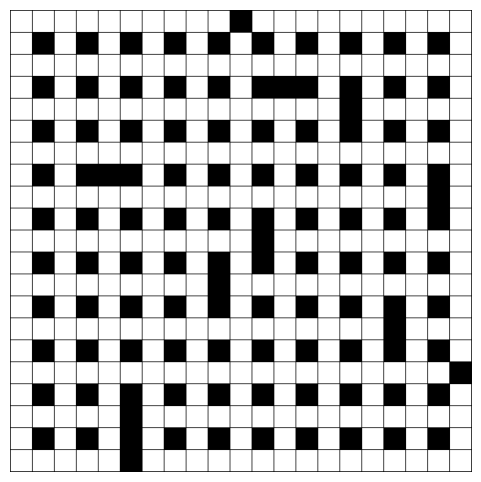

In [ ]:
visualize_crossword_image(grid, '*')

In [ ]:
def puz_to_json(fname):
    """ Converts a puzzle in .puz format to .json format
    """
    p = puz.read(fname)
    numbering = p.clue_numbering()

    grid = [[None for _ in range(p.width)] for _ in range(p.height)]
    for row_idx in range(p.height):
        cell = row_idx * p.width
        row_solution = p.solution[cell:cell + p.width]
        for col_index, item in enumerate(row_solution):
            if p.solution[cell + col_index:cell + col_index + 1] == '.':
                grid[row_idx][col_index] = 'BLACK'
            else:
                grid[row_idx][col_index] = ["", row_solution[col_index: col_index + 1]]

    across_clues = {}
    for clue in numbering.across:
        answer = ''.join(p.solution[clue['cell'] + i] for i in range(clue['len']))
        across_clues[str(clue['num'])] = [clue['clue'] + ' ', ' ' + answer]
        grid[int(clue['cell'] / p.width)][clue['cell'] % p.width][0] = str(clue['num'])

    down_clues = {}
    for clue in numbering.down:
        answer = ''.join(p.solution[clue['cell'] + i * numbering.width] for i in range(clue['len']))
        down_clues[str(clue['num'])] = [clue['clue'] + ' ', ' ' + answer]
        grid[int(clue['cell'] / p.width)][clue['cell'] % p.width][0] = str(clue['num'])


    mydict = {'metadata': {'date': None, 'rows': p.height, 'cols': p.width}, 'clues': {'across': across_clues, 'down': down_clues}, 'grid': grid}
    return mydict

def download_crossword(publication, publication_keyword, start_date, end_date, output_dir):
    if not os.path.exists(os.path.join(output_dir, publication)):
        os.mkdir(os.path.join(output_dir, publication))

    current_date = start_date

    while current_date <= end_date:
        formatted_date_str = current_date.strftime("%m/%d/%y")
        output_date_str = current_date.strftime("%m-%d-%Y")

        try:
            output_file_path = f"{output_dir}/{publication}/crossword_{output_date_str}.puz"
            command = f'xword-dl {publication_keyword} --date {formatted_date_str} -o {output_file_path}'
            subprocess.run(command, shell = True, check = True, stdout = subprocess.PIPE, text = True)
            print(f"Successfully downloaded for {publication}: Filename - crossword_{output_date_str}.puz")
        except:
            print(f"Error in downloading crossword for: {output_date_str}")

        current_date += datetime.timedelta(days = 1)

def convert_to_json(publication, puz_output_dir, json_output_dir):

    all_puz_files = glob.glob(os.path.join(puz_output_dir, publication, '*.puz'))

    if not os.path.exists(os.path.join(json_output_dir, publication)):
        os.mkdir(os.path.join(json_output_dir, publication))

    for puz_file_path in all_puz_files:
        json_output_path = puz_file_path.replace('.puz', '.json').replace('puz', 'json')
        json_data = puz_to_json(puz_file_path)
        with open(json_output_path, 'w') as f:
            json.dump(json_data, f)


publication_keyword = "sdpq"
publication = 'simply-daily-puzzles-quick'
start_date = datetime.date(2023, 12, 1)
end_date= datetime.date(2023, 12, 31)
puz_output_dir = "/content/puz"
json_output_dir = "/content/json"

# just make the puz directory
if not os.path.exists(puz_output_dir):
    os.mkdir(puz_output_dir)

# make publication specific directory
if not os.path.exists(os.path.join(puz_output_dir, publication)):
    os.mkdir(os.path.join(puz_output_dir, publication))


download_crossword(publication, publication_keyword, start_date, end_date, puz_output_dir)
# convert_to_json(publication, puz_output_dir, json_output_dir)

Successfully downloaded for simply-daily-puzzles-quick: Filename - crossword_12-01-2023.puz
Successfully downloaded for simply-daily-puzzles-quick: Filename - crossword_12-02-2023.puz
Successfully downloaded for simply-daily-puzzles-quick: Filename - crossword_12-03-2023.puz
Successfully downloaded for simply-daily-puzzles-quick: Filename - crossword_12-04-2023.puz
Successfully downloaded for simply-daily-puzzles-quick: Filename - crossword_12-05-2023.puz
Successfully downloaded for simply-daily-puzzles-quick: Filename - crossword_12-06-2023.puz
Successfully downloaded for simply-daily-puzzles-quick: Filename - crossword_12-07-2023.puz
Successfully downloaded for simply-daily-puzzles-quick: Filename - crossword_12-08-2023.puz
Successfully downloaded for simply-daily-puzzles-quick: Filename - crossword_12-09-2023.puz
Successfully downloaded for simply-daily-puzzles-quick: Filename - crossword_12-10-2023.puz
Successfully downloaded for simply-daily-puzzles-quick: Filename - crossword_12-

/content/puz/simply-daily-puzzles-quick/crossword_12-11-2023.puz


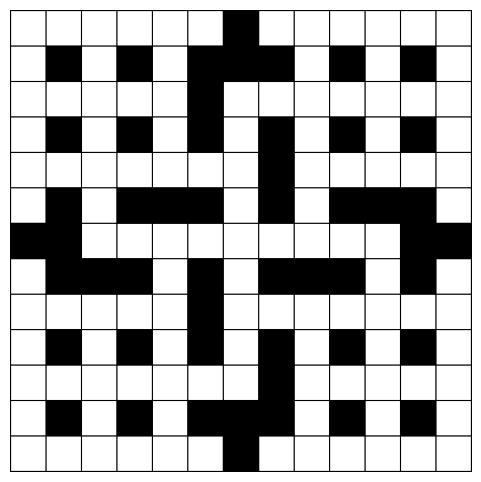

In [ ]:
puz_files = glob.glob(os.path.join(puz_output_dir, publication, '*.puz'))
selected = random.choice(puz_files)
print(selected)
json_grid_data = puz_to_json(selected)
grid_array = json_grid_data['grid']
rows, cols = json_grid_data['metadata']['rows'], json_grid_data['metadata']['cols']

grid_structure = []
for row in grid_array:
    row_array = []
    for col_element in row:
        if isinstance(col_element, list):
            row_array.append('')
        else:
            row_array.append('*') # using * for Black Cells

    grid_structure.append(row_array)

visualize_crossword_image(grid_structure, None)

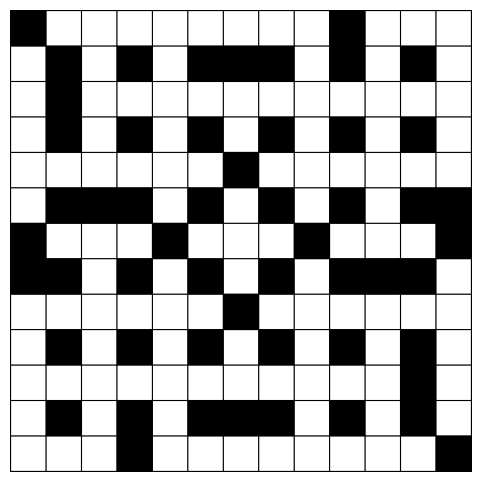

In [ ]:
### lets try-out making some british-style grids from above examples
grid_size = 13
rows = cols = grid_size
grid_array = [['W'] * cols for _ in range(rows)]

for row in range(1, rows, 2): # odd_places
    for col in range(1, cols, 2):
        grid_array[row][col] = 'B'

for i in range(0, ceil(rows / 2)): #even_places
    random_indices = random.sample(range(0, cols), random.randint(1, 2))
    for j in random_indices:
        grid_array[i][j] = 'B'
        grid_array[rows - 1 - i][cols - 1 - j] = 'B'

visualize_crossword_image(grid_array, 'B')

In [ ]:
import random

my_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]




[20, 4]